<a href="https://colab.research.google.com/github/RifkiGhifari/Kelompok_Lion_King_Pengetahuan_Islam/blob/main/Pengetahuan_Islam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Instalasi Library dan Impor Modul

In [2]:
!pip install -q pymupdf
!pip install -q sentence-transformers
!pip install -q bert-score
!pip install -q transformers torch


import fitz  # PyMuPDF untuk mengekstrak teks dari PDF
from sentence_transformers import SentenceTransformer  # Untuk menggunakan model Sentence Transformers
from sklearn.metrics.pairwise import cosine_similarity  # Untuk menghitung cosine similarity
import numpy as np
from transformers import pipeline  # Untuk menggunakan Hugging Face pipeline
from bert_score import score  # Untuk menghitung BERTScore
import matplotlib.pyplot as plt  # Untuk plotting hasil BERTScore


Fungsi Ekstraksi Teks dari PDF

In [11]:
# Fungsi untuk mengekstrak teks dari PDF
def extract_text_from_pdf(pdf_path):
    doc = fitz.open(pdf_path)
    text = ""
    for page_num in range(len(doc)):
        page = doc.load_page(page_num)
        text += page.get_text()
    return text


Mengunggah dan Mengekstrak Teks dari PDF

In [12]:
# Mengunggah file PDF (gunakan metode yang sesuai jika di Colab)
from google.colab import files
uploaded = files.upload()
pdf_path = list(uploaded.keys())[0]

# Mengekstrak teks dari PDF
text = extract_text_from_pdf(pdf_path)

# Membagi teks menjadi halaman untuk dimasukkan ke FAISS
pages = [{"page_content": page} for page in text.split("\n\n")]



Saving baru.pdf to baru.pdf


Inisialisasi dan Pengkodean Model Sentence Transformers

In [13]:
# Menginisialisasi model sentence-transformers
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Mendapatkan embeddings untuk setiap halaman
embeddings = model.encode([page['page_content'] for page in pages])


Fungsi Pencarian Kesamaan

In [54]:
# Fungsi untuk melakukan pencarian kesamaan
def similarity_search(query, embeddings, pages, model, top_k=5):
    query_embedding = model.encode([query])
    similarities = cosine_similarity(query_embedding, embeddings)
    top_k_indices = np.argsort(similarities[0])[-top_k:][::-1]
    return [pages[i] for i in top_k_indices]


Meminta dan Memproses Pertanyaan Pengguna

In [55]:
# Meminta pengguna untuk memasukkan pertanyaan
query = input("Masukkan pertanyaan Anda: ")

# Melakukan pencarian kesamaan
docs = similarity_search(query, embeddings, pages, model)

# Menggabungkan konten yang relevan
content = "\n".join([x["page_content"] for x in docs])


Masukkan pertanyaan Anda: Bagaimana cara menjalankan ibadah shalat dalam Islam? 


Menginisialisasi dan Memilih Model QA dari Hugging Face

In [61]:
# Menggunakan pipeline QA Hugging Face dengan penanganan kesalahan
try:
    qa_model = pipeline("question-answering", model="indobenchmark/indobert-lite-large-p2", tokenizer="indobenchmark/indobert-lite-large-p2")
except Exception as e:
    print(f"Error dengan model indobenchmark: {e}")
    print("Menggunakan model alternatif xlm-roberta-base")
    qa_model = pipeline("question-answering", model="xlm-roberta-base", tokenizer="xlm-roberta-base")


Some weights of AlbertForQuestionAnswering were not initialized from the model checkpoint at indobenchmark/indobert-lite-large-p2 and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Error dengan model indobenchmark: not a string
Menggunakan model alternatif xlm-roberta-base


Some weights of XLMRobertaForQuestionAnswering were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Melakukan Inferensi dan Menampilkan Jawaban yang Dihasilkan

In [62]:
# Melakukan inferensi
qa_input = {"question": query, "context": content}
result = qa_model(qa_input)
generated_answer = result['answer']

# Menampilkan jawaban yang dihasilkan
print("Jawaban yang dihasilkan:", generated_answer)


Jawaban yang dihasilkan: waktu-waktu yang telah ditentukan:


Evaluasi Menggunakan BERTScore

BERTScore Precision: 0.78
BERTScore Recall: 0.61
BERTScore F1: 0.68


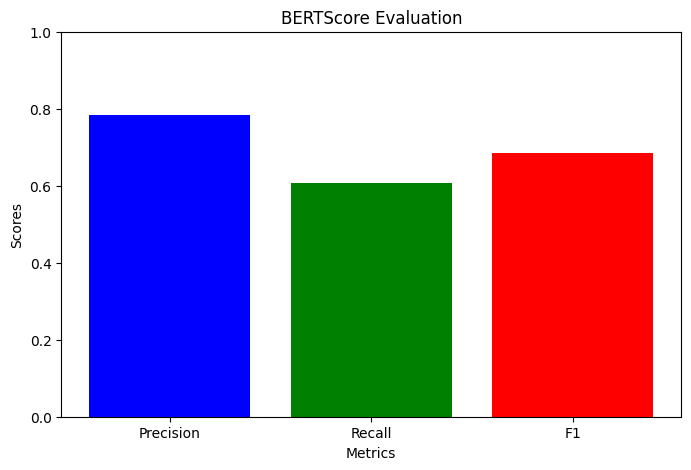

In [63]:
# Jawaban referensi (ganti ini dengan jawaban yang benar untuk evaluasi)
reference_answer = "Shalat dalam Islam dilakukan lima kali sehari pada waktu-waktu yang telah ditentukan: Subuh, Dhuhur, Ashar, Maghrib, dan Isya. Setiap shalat terdiri dari gerakan dan bacaan tertentu yang harus dilakukan oleh Muslim."

if reference_answer:
    # Menghitung BERTScore
    P, R, F1 = score([generated_answer], [reference_answer], lang="id")

    # Menyederhanakan output menjadi dua tempat desimal
    P_mean = P.mean().item()
    R_mean = R.mean().item()
    F1_mean = F1.mean().item()

    print(f"BERTScore Precision: {P_mean:.2f}")
    print(f"BERTScore Recall: {R_mean:.2f}")
    print(f"BERTScore F1: {F1_mean:.2f}")

    # Plot hasil BERTScore
    scores = [P_mean, R_mean, F1_mean]
    labels = ['Precision', 'Recall', 'F1']

    plt.figure(figsize=(8, 5))
    plt.bar(labels, scores, color=['blue', 'green', 'red'])
    plt.ylim(0, 1)
    plt.xlabel('Metrics')
    plt.ylabel('Scores')
    plt.title('BERTScore Evaluation')
    plt.show()
else:
    print("Tidak ada jawaban referensi yang dimasukkan. Evaluasi BERTScore tidak dilakukan.")
